In [182]:
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
import re
from itertools import combinations

In [183]:
with open("C:\\Users\\tonys\\OneDrive\\Рабочий стол\\Data_task3\\Scooby Doo_0267913.json", "r", encoding='utf-8') as f:
    script = json.load(f)

UNIGRAM_FREQ_FILE = "ПУТЬ К ФАЙЛУ\\unigram_freq.csv"  
POSITIVE_WORDS_FILE = "ПУТЬ К ФАЙЛУ\\positive.txt"  
NEGATIVE_WORDS_FILE = "ПУТЬ К ФАЙЛУ\\negative.txt"  

In [184]:
# сбор реплик
replicas = []
for scene_idx, scene in enumerate(script):
    for entry in scene:
        if entry.get("head_type") == "heading":  # Условие фильтрации
            subj = entry["head_text"].get("subj")  # Имя персонажа
            text = entry["text"]  # Реплика
            
            # Фильтр реплик
            if subj and subj != "CONTINUED":
                replicas.append({
                    "scene": scene_idx,
                    "subj": subj,
                    "text": text
                })

# перобр в dataframe
df = pd.DataFrame(replicas)

In [185]:
def filter_characters(df):
    scene_terms = {
        'BACKTOSCENE', 'CONTINUED', 'COOLSVILLEASTROCONPRESENTS', 'COMMERCIALOUTTAKES',
        'CUTTO', 'EXTBEACH', 'FADETO', 'FLASHBACK', 'GRAINYTVFOOTAGE', 'MAGAZINEHEADLINE',
        'PCGAMINGCOVER', 'POSTERAD', 'SERIESOFSHOTS', 'SPLITSCREEN', 'STARTCREDITSEQUENCE',
        'SUPERIMPOSE', 'SUPERIMPOSEINACOLORFULGROOVYFONT', 'TEENBEATCOVER', 'THEEND',
        'TVFOOTAGE', 'USMAGAZINECOVER', 'VARIETYCOVER', 'ANOTHERTAKE', 'CREEMCOVER',
        'WELCOETOSPORYISLAND', 'WHEREFEARISYURONLYFRIEND', 'BACKTOCATACOMBOFFICE',
        'ANCIENTILLUSTRATION', 'CORESPONDENT', 'DAY', 'INTERVIEW', 'PAGE', 'MIRROR', 'SPLIT-SCREEN'
    }
    
    # функция для разделения составных имен
    def split_compound_names(name):
        # заменяем " AND " и "&" на "/" для унификации
        name = re.sub(r'\s+AND\s+|\s*&\s*', '/', name, flags=re.IGNORECASE)
        # Разделяем по "/" и выбираем первую часть 
        return [part.strip() for part in name.split('/') if part.strip()]
    
    # очистка имен персонажей. удаление _,  O.S-полобных фрагментов, нумерации и лишние пробелы
    df['subj_cleaned'] = df['subj'].str.replace(r'^[,_]', '', regex=True)  
    df['subj_cleaned'] = df['subj_cleaned'].str.replace(r'[,_].*$', '', regex=True)  
    df['subj_cleaned'] = df['subj_cleaned'].str.replace(r'\(.*\)', '', regex=True)  
    df['subj_cleaned'] = df['subj_cleaned'].str.replace(r'^\d+\.\s*', '', regex=True)  
    df['subj_cleaned'] = df['subj_cleaned'].str.strip()  
    
    # тут происходит разделение на составные имена и создание новых строк для каждого персонажа
    df_expanded = df.copy()
    df_expanded['subj_cleaned'] = df_expanded['subj_cleaned'].apply(split_compound_names)
    df_expanded = df_expanded.explode('subj_cleaned')
    
    # нормализация имен subj
    df_expanded['subj_normalized'] = df_expanded['subj_cleaned'].str.upper().str.replace(' ', '')
    
    # фильтр по техническим терминам, именам короче 3 символов и не пустым именам
    df_filtered = df_expanded[
        (~df_expanded['subj_normalized'].isin(scene_terms)) &  
        (df_expanded['subj_cleaned'].str.len() >= 3) &        
        (df_expanded['subj_cleaned'] != '')                   
    ].copy()
    
    # доп очистка имен
    df_filtered.loc[:, 'subj_cleaned'] = df_filtered['subj_cleaned'].str.strip()
    df_filtered.loc[:, 'subj_normalized'] = df_filtered['subj_cleaned'].str.upper().str.replace(' ', '')
    
    return df_filtered

# применяю фильтрацию
df_filtered = filter_characters(df)

=== Задача 1: База данных реплик главных героев ===

Сцена с наибольшим числом реплик главных героев: 58

Пример реплик из этой сцены:
     scene    subj                                               text  \
460     58  SHAGGY  But... like... that isn’t what happened... lik...   
462     58  SHAGGY  These guys have zippers on their backs! N‘GOO ...   
463     58  SHAGGY  Last night they were... big! N‘GOO (to Raimond...   
464     58  SHAGGY  They had teeth... they breathed The "Demon" pr...   
466     58  DAPHNE  Lieutenant. Our friends Fred and Velma are mis...   

    subj_cleaned subj_normalized  
460       SHAGGY          SHAGGY  
462       SHAGGY          SHAGGY  
463       SHAGGY          SHAGGY  
464       SHAGGY          SHAGGY  
466       DAPHNE          DAPHNE  

=== Задача 2: Анализ реплик персонажей ===

Всего персонажей: 33

Список всех персонажей:
['SHAGGY', 'FRED', 'DAPHNE', 'SCOOBY', 'VELMA', 'MONDAVARIOUS', 'RAIMONDO', 'GARRET', 'ISABEL', 'MANDY', 'ZARKOS', 'PATIENT',

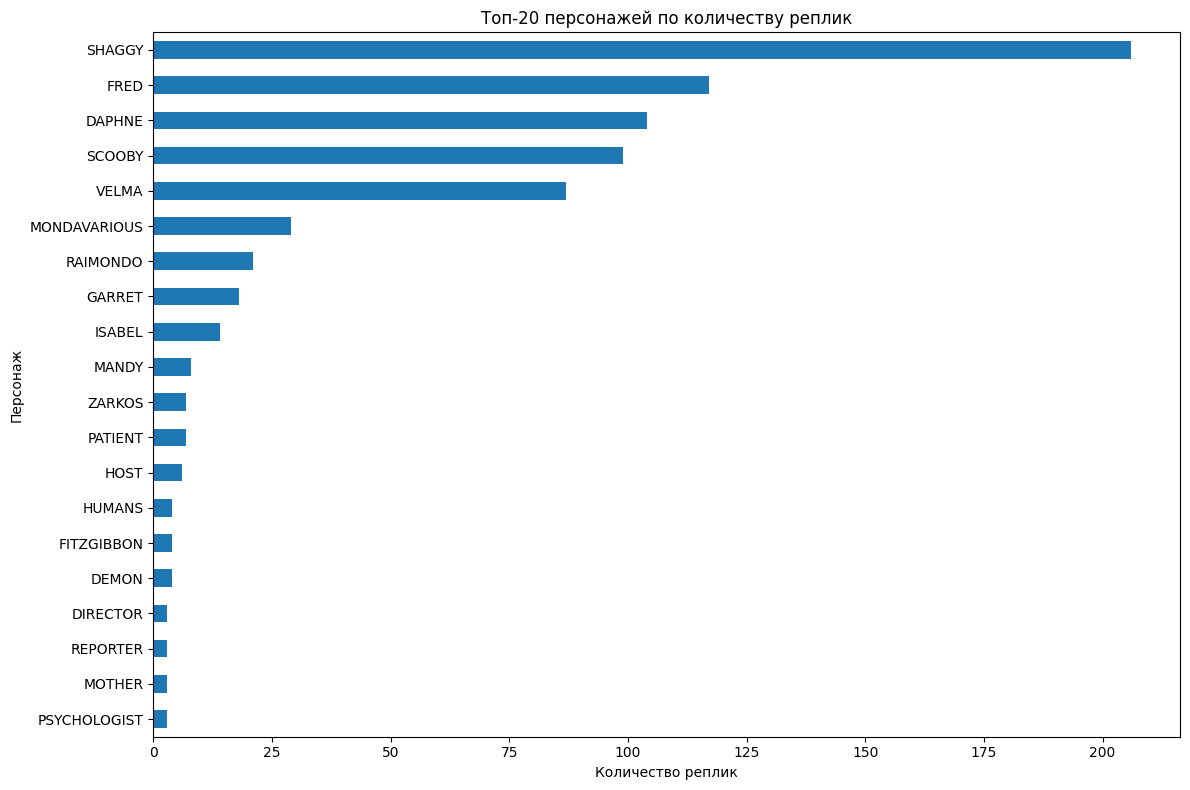

In [186]:
def analyze_character_dialogs(df_filtered):
    # БД реплик главных героев
    main_characters = ['SCOOBY', 'SHAGGY', 'DAPHNE', 'FRED', 'VELMA']
    main_char_db = df_filtered[df_filtered['subj_normalized'].isin([c.upper().replace(' ', '') for c in main_characters])]
    
    # находим сцену с наибольшим числом реплик
    if not main_char_db.empty:
        scene_with_most_replics = main_char_db['scene'].value_counts().idxmax()
        print("=== Задача 1: База данных реплик главных героев ===")
        print(f"\nСцена с наибольшим числом реплик главных героев: {scene_with_most_replics}")
        print("\nПример реплик из этой сцены:")
        print(main_char_db[main_char_db['scene'] == scene_with_most_replics].head())
    
    # анализ реплик subj
    char_replics = df_filtered['subj_cleaned'].value_counts()
    
    # фильтр subj, оставляя только тех, которые состоят из одного слова
    filtered_char_replics = char_replics[char_replics.index.str.split().str.len() == 1]
    
    print("\n=== Задача 2: Анализ реплик персонажей ===")
    print(f"\nВсего персонажей: {len(filtered_char_replics)}")
    print(f"\nСписок всех персонажей:\n{filtered_char_replics.index.tolist()}")
    
    # Визуализация топ-20 персонажей
    plt.figure(figsize=(12, 8))
    filtered_char_replics[:20].sort_values().plot(kind='barh')
    plt.title('Топ-20 персонажей по количеству реплик')
    plt.xlabel('Количество реплик')
    plt.ylabel('Персонаж')
    plt.tight_layout()
    plt.show()
    
    return main_char_db

main_char_db = analyze_character_dialogs(df_filtered)

<Figure size 1200x800 with 0 Axes>

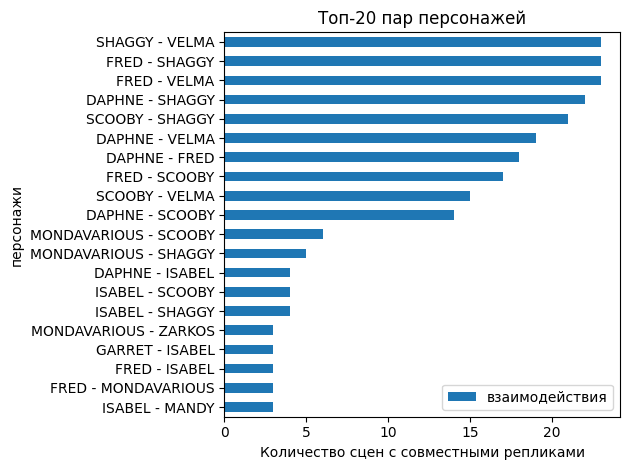

In [187]:
#Анализ взаимодействий персонажей
def analyze_character_interactions(df_filtered):
    # Создаем список всех пар персонажей в каждой сцене
    interactions = []
    for scene, group in df_filtered.groupby('scene'):
        chars_in_scene = group['subj_normalized'].unique()
        for pair in combinations(chars_in_scene, 2):
            interactions.append(tuple(sorted(pair)))

    # Считаем количество взаимодействий
    interaction_counts = Counter(interactions)
    top_interactions = interaction_counts.most_common(20)

    # визуализация топ-20 пар
    interaction_df = pd.DataFrame(top_interactions, columns=['персонажи', 'взаимодействия'])
    interaction_df['персонажи'] = interaction_df['персонажи'].apply(lambda x: f"{x[0]} - {x[1]}")

    plt.figure(figsize=(12, 8))
    interaction_df.sort_values('взаимодействия').plot(kind='barh', x='персонажи', y='взаимодействия')
    plt.title('Топ-20 пар персонажей')
    plt.xlabel('Количество сцен с совместными репликами')
    plt.tight_layout()
    plt.show()
    
    return interaction_counts
    
interaction_counts = analyze_character_interactions(df_filtered)

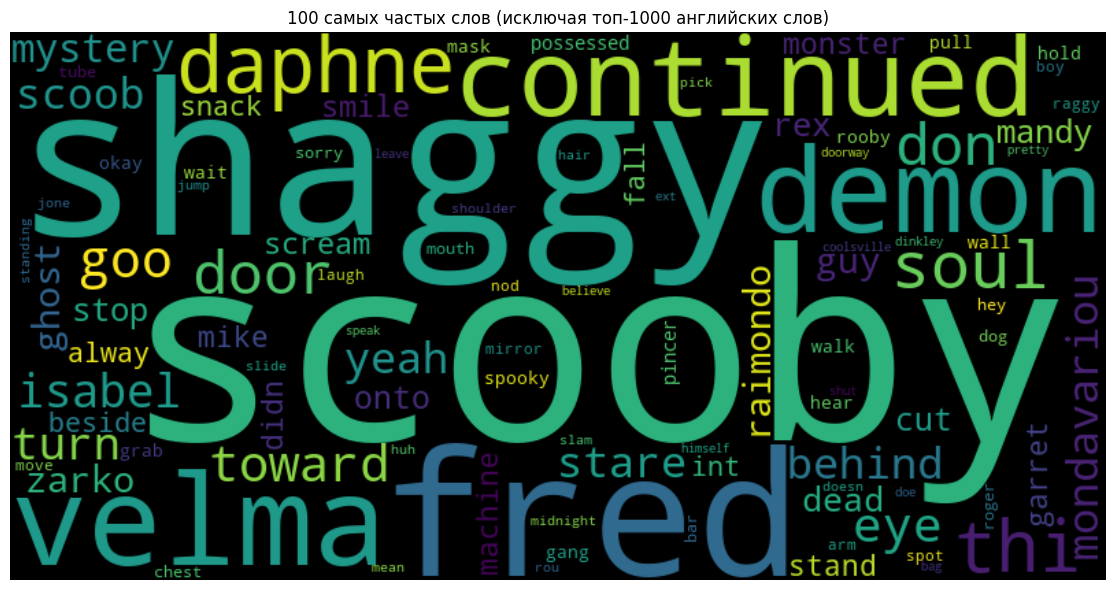

In [188]:
def normalize_word(word):
    word = word.lower()
    # корректировка/удаление
    word = re.sub(r"'s$", "", word)  # boy's → boy
    word = re.sub(r"s'$", "", word)   # boys' → boy
    word = re.sub(r"s$", "", word)    # boys → boy
    return word

# сбор всех слов из реплик
all_words = []
for r in replicas:
    words = re.findall(r"\b[\w'-]+\b", r["text"])  # Учитываем слова с апострофами
    all_words.extend([normalize_word(w) for w in words if w.isalpha()])  # исключение цифр и символов

# загрузка и фильтрация стоп-слов
try:
    stopwords = set(pd.read_csv(UNIGRAM_FREQ_FILE)["word"].str.lower().head(1000))
    filtered_words = [w for w in all_words if w not in stopwords and len(w) > 2]  # исключаем слова < 2
except Exception as e:
    print(f"Ошибка при загрузке файла стоп-слов: {e}")
    filtered_words = [w for w in all_words if len(w) > 2]  # используем только фильтр по длине

# подсчет частотности 
word_counts = Counter(filtered_words)
top_words = dict(word_counts.most_common(100))

# создание облака 
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='black',
    colormap='viridis',
    max_words=100
).generate_from_frequencies(top_words)

# визуализация облака
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("100 самых частых слов (исключая топ-1000 английских слов)")
plt.tight_layout()
plt.show()

In [189]:
# загрузка словарей настроений
def load_sentiment_words(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return set(word.strip().lower() for word in f.readlines())
    except Exception as e:
        print(f"Ошибка загрузки файла {file_path}: {e}")
        return set()

positive_words = load_sentiment_words(POSITIVE_WORDS_FILE)
negative_words = load_sentiment_words(NEGATIVE_WORDS_FILE)

# загрузка 
try:
    common_words = set(pd.read_csv(UNIGRAM_FREQ_FILE)["word"].str.lower().head(1000))
except Exception as e:
    print(f"Ошибка загрузки файла частых слов: {e}")
    common_words = set()

# нормализация слов
def normalize_word(word):
    word = word.lower()
    word = re.sub(r"'s$", "", word)
    word = re.sub(r"s'$", "", word)
    word = re.sub(r"s$", "", word)
    return word

In [190]:
# анализ настроения subj
def analyze_character_sentiment(replicas):
    char_sentiment = defaultdict(lambda: {'positive': 0, 'negative': 0, 'common': 0, 'neutral': 0, 'total': 0})
    
    for r in replicas:
        subj = r['subj']
        words = re.findall(r"\b[\w'-]+\b", r['text'])
        
        for word in words:
            if not word.isalpha():
                continue
                
            normalized = normalize_word(word)
            char_sentiment[subj]['total'] += 1
            
            if normalized in positive_words:
                char_sentiment[subj]['positive'] += 1
            elif normalized in negative_words:
                char_sentiment[subj]['negative'] += 1
            elif normalized in common_words:
                char_sentiment[subj]['common'] += 1
            else:
                char_sentiment[subj]['neutral'] += 1
    
    # конверт в dataframe (для удобства)
    sentiment_df = pd.DataFrame.from_dict(char_sentiment, orient='index')
    
    # добавляем доли
    for col in ['positive', 'negative', 'common', 'neutral']:
        sentiment_df[f'{col}_ratio'] = sentiment_df[col] / sentiment_df['total']
    
    return sentiment_df

In [191]:
# анализ настроения по сценам
def analyze_scene_sentiment(replicas):
    scene_sentiment = defaultdict(lambda: {'positive': 0, 'negative': 0, 'common': 0, 'neutral': 0, 'total': 0})
    
    for r in replicas:
        scene = r['scene']
        words = re.findall(r"\b[\w'-]+\b", r['text'])
        
        for word in words:
            if not word.isalpha():
                continue
                
            normalized = normalize_word(word)
            scene_sentiment[scene]['total'] += 1
            
            if normalized in positive_words:
                scene_sentiment[scene]['positive'] += 1
            elif normalized in negative_words:
                scene_sentiment[scene]['negative'] += 1
            elif normalized in common_words:
                scene_sentiment[scene]['common'] += 1
            else:
                scene_sentiment[scene]['neutral'] += 1
    
    # сортировка по номеру сцены
    scene_sentiment = dict(sorted(scene_sentiment.items()))
    
    # конверт в dataframe
    scene_df = pd.DataFrame.from_dict(scene_sentiment, orient='index')
    
    # добавляю доли и баланс настроения
    scene_df['positive_ratio'] = scene_df['positive'] / scene_df['total']
    scene_df['negative_ratio'] = scene_df['negative'] / scene_df['total']
    scene_df['sentiment_balance'] = scene_df['positive_ratio'] - scene_df['negative_ratio']
    
    return scene_df

In [192]:
# визуализация настроения subj
def plot_character_sentiment(sentiment_df, top_n=10):
    # топ-N subj по количеству реплик
    top_chars = sentiment_df.nlargest(top_n, 'total').index
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # столбчатый график отгруппированный
    sentiment_df.loc[top_chars][['positive_ratio', 'negative_ratio', 'common_ratio', 'neutral_ratio']].plot(
        kind='bar', stacked=True, ax=ax,
        color=['green', 'red', 'blue', 'gray']
    )
    
    plt.title('Распределение настроений по персонажам')
    plt.ylabel('Доля слов')
    plt.xlabel('Персонаж')
    plt.xticks(rotation=45)
    plt.legend(['Позитивные', 'Негативные', 'Общие', 'Нейтральные'])
    plt.tight_layout()
    plt.show()

In [193]:
# визуализация настроения по сценам
def plot_enhanced_scene_sentiment(scene_df):
    plt.figure(figsize=(14, 7))
    
    # данные для графика
    scenes = scene_df.index
    pos = scene_df['positive_ratio']
    neg = scene_df['negative_ratio']
    
    # График позитивных слов (green)
    plt.bar(scenes, pos, color='green', alpha=0.6, label='Позитивные слова')
    
    # график негативных слов (red)
    plt.bar(scenes, -neg, color='red', alpha=0.6, label='Негативные слова')
    
    # линия нулевого баланса
    plt.axhline(0, color='black', linewidth=0.8)
    
    # линия баланса
    plt.plot(scenes, scene_df['sentiment_balance'], 
             color='purple', marker='o', linestyle='-', 
             linewidth=2, markersize=5, label='Баланс настроения')
    
    plt.title('Эмоциональный профиль фильма по сценам', pad=20)
    plt.xlabel('Номер сцены')
    plt.ylabel('Эмоциональная окраска')
    plt.legend(loc='upper right')
    
    # добавляем подписи для крайних значений
    max_pos = scene_df['positive_ratio'].idxmax()
    max_neg = scene_df['negative_ratio'].idxmax()
    
    plt.annotate(f"Самый позитивный\n(сцена {max_pos})", 
                 xy=(max_pos, pos[max_pos]), 
                 xytext=(10, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->"))
    
    plt.annotate(f"Самый негативный\n(сцена {max_neg})", 
                 xy=(max_neg, -neg[max_neg]), 
                 xytext=(-60, -20), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->"))
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show() 

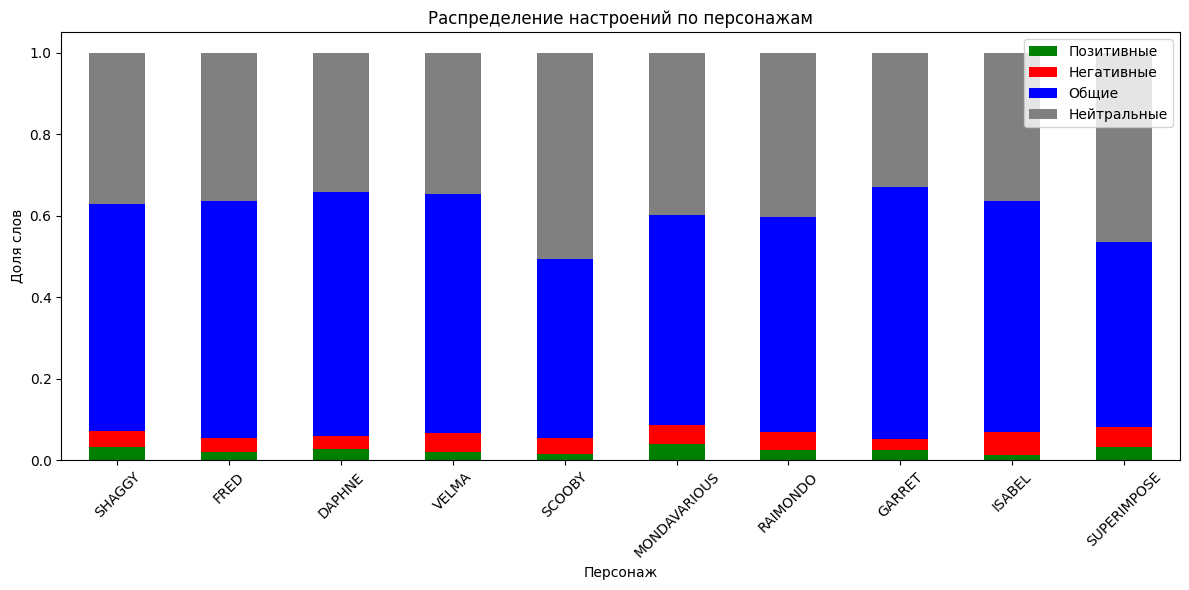

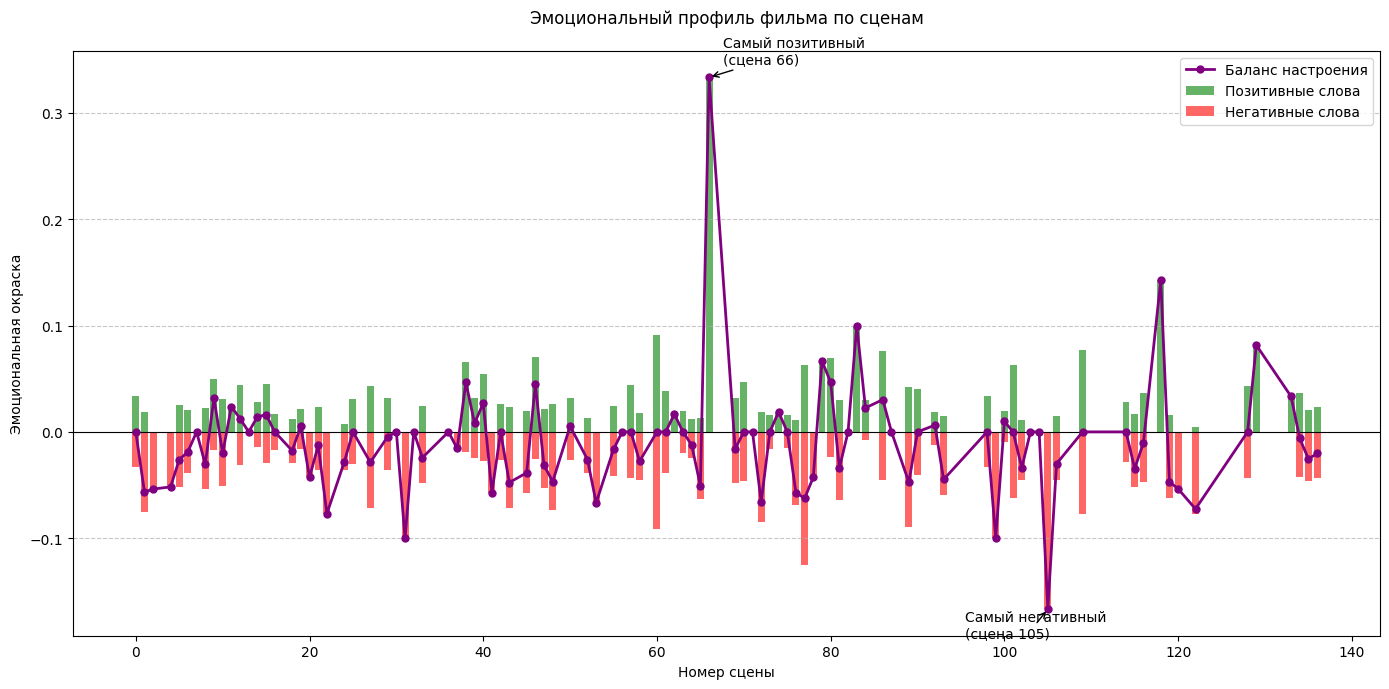

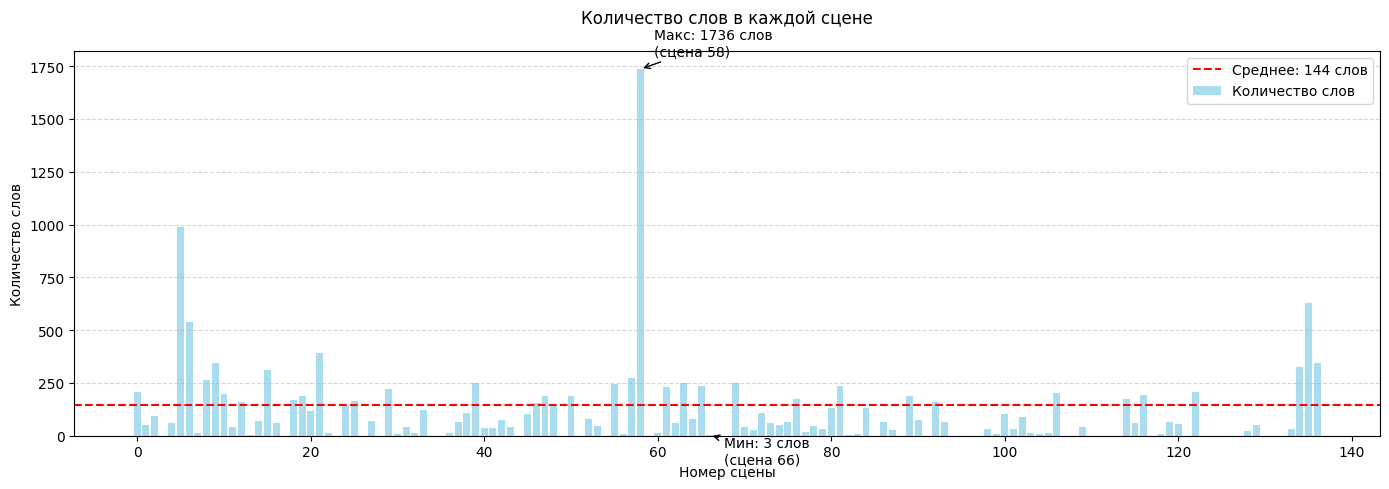


Топ-10 персонажей по настроению:
              positive_ratio  negative_ratio
SHAGGY              0.032486        0.038250
FRED                0.021189        0.034726
DAPHNE              0.027159        0.033426
VELMA               0.020301        0.047368
SCOOBY              0.014525        0.039106
MONDAVARIOUS        0.040070        0.047038
RAIMONDO            0.026442        0.043269
GARRET              0.024221        0.027682
ISABEL              0.014019        0.056075
SUPERIMPOSE         0.031447        0.050314


In [196]:
#БЛОК ВЫВОДА
# основной анализ
character_sentiment = analyze_character_sentiment(replicas)
scene_sentiment = analyze_scene_sentiment(replicas)

# визуализация 
plot_character_sentiment(character_sentiment)
plot_enhanced_scene_sentiment(scene_sentiment)
plot_scene_word_counts(scene_sentiment)  

# вывод результатов
print("\nТоп-10 персонажей по настроению:")
print(character_sentiment.nlargest(10, 'total')[['positive_ratio', 'negative_ratio']])

In [197]:
# Сначала получаем общее количество уникальных сцен из исходных данных
all_scenes = set(r['scene'] for r in replicas)
total_scenes = len(all_scenes)

# Затем создаем таблицу с правильными значениями
scene_stats_rus = pd.DataFrame({
    'Метрика': ['сцен в фильме', 
                'Сцены с анализируемыми репликами',
                'Средний баланс настроения', 
                'Средний % позитивных слов', 
                'Средний % негативных слов',
                'Мин. слов в сцене', 
                'Макс. слов в сцене',
                'Среднее слов в сцене'],
    'Значение': [
        f"{total_scenes}",
        f"{len(scene_sentiment)} ({len(scene_sentiment)/total_scenes:.1%})",
        f"{scene_sentiment['sentiment_balance'].mean():+.2f}", 
        f"{scene_sentiment['positive_ratio'].mean():.2%}",
        f"{scene_sentiment['negative_ratio'].mean():.2%}",
        f"{int(scene_sentiment['total'].min())}",
        f"{int(scene_sentiment['total'].max())}",
        f"{int(scene_sentiment['total'].mean())}"
    ]
})

# Вывод таблицы
from IPython.display import display, HTML
display(HTML(scene_stats_rus.to_html(index=False, justify='center')))

Метрика,Значение
сцен в фильме,100
Сцены с анализируемыми репликами,100 (100.0%)
Средний баланс настроения,-0.01
Средний % позитивных слов,2.96%
Средний % негативных слов,3.82%
Мин. слов в сцене,3
Макс. слов в сцене,1736
Среднее слов в сцене,143
